# Generate Hot Off Gas Background (511-keV gammas)

Copied from https://github.com/yuntsebaryon/SimpleCosmics/blob/main/HOG/genHOG.ipynb, but change to create hepevt files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
outdir = '/Users/yuntse/data/coherent/SNeNDSens/gen/HOG'

if os.path.exists(outdir):
    raise FileExistsError(f"Directory '{outdir}' already exists!")
else:
    os.makedirs(outdir)

## Generate the location and time: xyzt

__Update the coordinate__

Per the HOG shielding briefing (https://coherent.phy.duke.edu/w/img_auth.php/7/78/HOGShieldingBriefing.pdf), the distance between the side of the upstream wall facing neutrino alley and the side of the downstream wall facing neutrino alley is 10' 11" (3.33m). Then, since the upstream wall is a at a y-position of ~~-1.7m~~ -55cm, the downstream wall must be at a y-position of ~~1.63m~~ 278cm. From the HOG shielding load calculation (https://coherent.phy.duke.edu/w/img_auth.php/f/f5/Lead_Shield_Support_Structure_Analysis.pdf), the HOG pipe is 37.5" from the downstream wall. This gives us a y-position of ~~0.675m~~ 182.5cm.

The top of the floor is at a z-position of ~~-0.64m~~ -67cm, and the HOG pipe is 84" above the floor from the HOG shielding load calculation. This gives us a z-position of ~~1.49m~~ 146cm.

The lead shielding around the HOG pipeline has an inner radius of 4", or 0.102m. 

In [3]:
HOG_CENTER = (0, 182.5, 146)
HOG_RADIUS = 10.2

# location and time in [cm, ns]
def assignXYZT(xlim, thetamin, thetamax, tlow, thigh, nSamples):
    theta_pos = np.random.uniform(thetamin, thetamax, nSamples)
    x_pos = HOG_CENTER[0] + np.random.uniform(-xlim, xlim, nSamples)
    y_pos = HOG_CENTER[1] + HOG_RADIUS * np.cos(theta_pos)
    z_pos = HOG_CENTER[2] + HOG_RADIUS * np.sin(theta_pos)
    
    xyzt = np.column_stack((x_pos, y_pos, z_pos, np.random.uniform(tlow, thigh, nSamples)))
    return xyzt

In [4]:
# isotropic direction assignment
def assignPXYZ(p_total, nSamples):

    costheta = np.random.uniform(-1., 1., nSamples)
    sintheta = np.sqrt( 1. - costheta**2 )
    phi = np.random.uniform(0., 2.*np.pi, nSamples)
    px = p_total*sintheta*np.cos(phi)
    py = p_total*sintheta*np.sin(phi)
    pz = p_total*costheta

    return np.column_stack((px, py, pz))

In [5]:
gPdg = 22
# unit: GeV
gMass = 0
gEnergy = 511e-6

In [6]:
# unit: cm, ns
xlim = 50
thetamin = 0
thetamax = 2*np.pi
tlow = -30000
# thigh = 300000
thigh = 188000

(-50.0, 200.0)

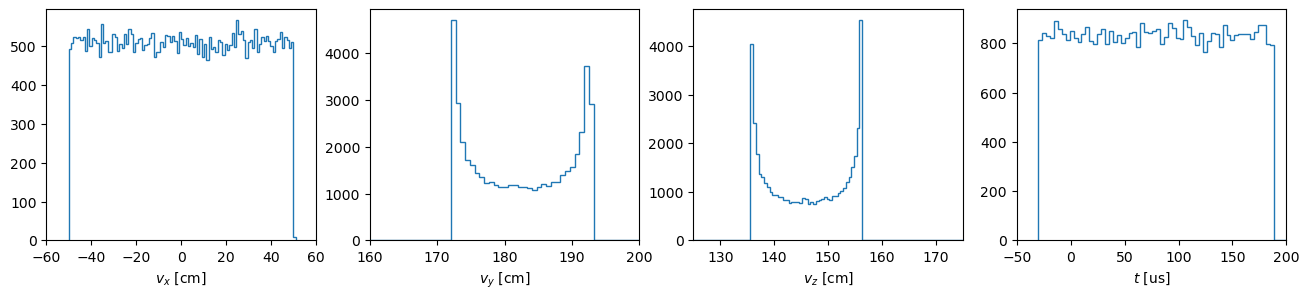

In [7]:
fig, ax = plt.subplots(1, 4, figsize = (16, 3))

xyzt = assignXYZT(xlim, thetamin, thetamax, tlow, thigh, 50000)

ax[0].hist(xyzt[:,0], bins = np.linspace(-50, 51, 100), histtype = 'step')
ax[0].set_xlabel(r'$v_x$ [cm]')
ax[0].set_xlim([-60, 60])

ax[1].hist(xyzt[:,1], bins = np.linspace(160, 230, 100), histtype = 'step')
ax[1].set_xlabel(r'$v_y$ [cm]')
ax[1].set_xlim([160, 200])

ax[2].hist(xyzt[:,2], bins = np.linspace(125, 175, 100), histtype = 'step')
ax[2].set_xlabel(r'$v_z$ [cm]')
ax[2].set_xlim([125, 175])

ax[3].hist(xyzt[:,3] / 1000, bins = np.linspace(-30, 330, 100), histtype = 'step')
ax[3].set_xlabel(r'$t$ [us]')
ax[3].set_xlim( [-50, 200] )

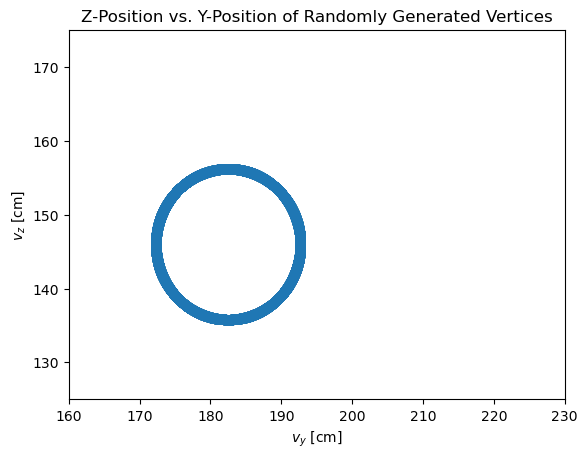

In [8]:
plt.scatter(xyzt[:,1], xyzt[:,2])
plt.xlabel(r'$v_y$ [cm]')
plt.ylabel(r'$v_z$ [cm]')
plt.xlim([160, 230])
plt.ylim([125, 175])
plt.title('Z-Position vs. Y-Position of Randomly Generated Vertices')
plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter
    
class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
        
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
        
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

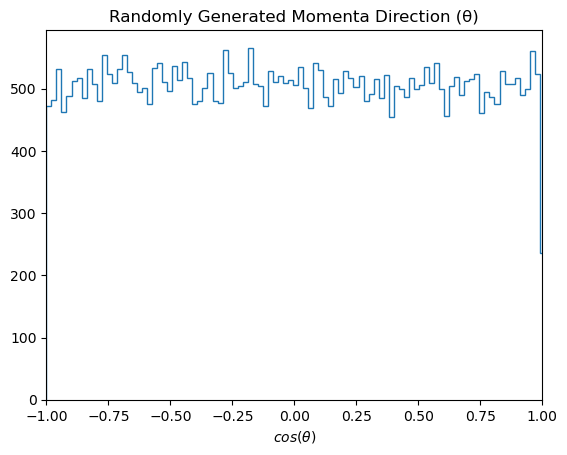

In [10]:
pxyz = assignPXYZ(gEnergy*1e6, 50000)
costh = pxyz[:,2]/511

plt.hist(costh, bins = np.linspace(-1, 1.01, 100), histtype = 'step')
plt.xlabel(r'$cos(θ)$')
plt.title('Randomly Generated Momenta Direction (θ)')
plt.xlim([-1, 1])
plt.show()

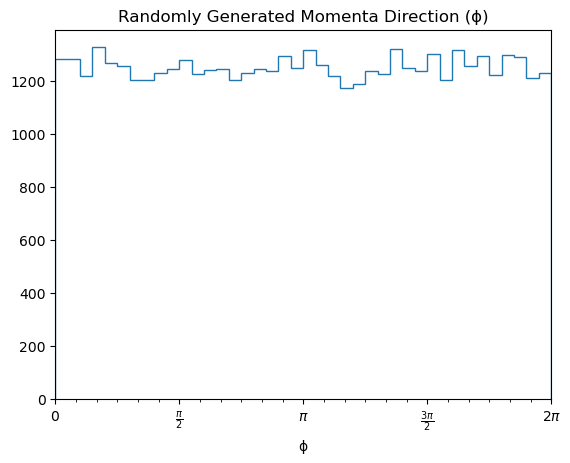

In [11]:
phi = np.zeros(len(pxyz))
y_mask = pxyz[:,1] >= 0
phi[y_mask] = np.arccos(pxyz[:,0][y_mask] / np.sqrt(pxyz[:,0][y_mask]**2 + pxyz[:,1][y_mask]**2))
phi[~y_mask] = 2*np.pi - np.arccos(pxyz[:,0][~y_mask] / np.sqrt(pxyz[:,0][~y_mask]**2 + pxyz[:,1][~y_mask]**2))

plt.hist(phi, bins=np.arange(0, 2.05*np.pi, 0.05*np.pi), histtype='step')
plt.xlim(0, 2*np.pi)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

# Axis labels
plt.xlabel('ɸ')
plt.title('Randomly Generated Momenta Direction (ɸ)')

plt.show()

## Calculation of gamma scale factor

This calculation is based on the measured (non-shielded) flux of 25 gamma / (cm^2 s) at 5 ft (152.4 cm) away from the HOG pipeline. Then, using a cylindrical generating source of radius 10.2cm gives us:

(25 gamma/(cm^2 s)) * (5ft / 10.2cm) * 2pi * (10.2cm) * (Length of Simulated Pipe).

In [12]:
nEvents = 100000
avgNumGammaPerEvent = 2*(thetamax - thetamin)*25*152.4*xlim*(thigh - tlow)*1.e-9
numGammaPerEvent = np.random.poisson(lam=avgNumGammaPerEvent, size=nEvents)
nParticlePerVtx = 1
nEventPerFile = 10000
nFiles = int(nEvents/nEventPerFile)
avgNumGammaPerEvent, nFiles

(521.868805243722, 10)

In [13]:
for iFile in range(nFiles):
    outFile = f'{outdir}/HOG_{iFile:04d}.hepevt'

    with open(outFile, 'w') as f:
        for iEvtPerFile in range(nEventPerFile):
            iEvt = iFile*nEventPerFile + iEvtPerFile

            # assign xyzt and pxyz
            xyzt = assignXYZT(xlim, thetamin, thetamax, tlow, thigh, numGammaPerEvent[iEvt])
            pxyz = assignPXYZ(gEnergy, numGammaPerEvent[iEvt])
            
            for iGamma in range(numGammaPerEvent[iEvt]):
                f.write( f'{iEvt} {iGamma} {nParticlePerVtx}\n')

                # ISTHEP IDHEP JMOHEP1 JMOHEP2 JDAHEP1 JDAHEP2 PHEP1 PHEP2 PHEP3 PHEP4 PHEP5 VHEP1 VHEP2 VHEP3 VHEP4
                # final-state particle
                ISTHEP = 1
                IDHEP = gPdg
                
                # The JMOHEP1, JMOHEP2, JDAHEP1, and JDAHEP2 entries record the indices (between 1 and NHEP, inclusive) 
                # of particles in the event record that correspond to the first mother, second mother, first daughter, 
                # and last daughter of the current particle, respectively. 
                JMOHEP1 = 0
                JMOHEP2 = 0
                JDAHEP1 = 0
                JDAHEP2 = 0
                
                # Fill momentum
                PHEP1 = pxyz[iGamma][0]
                PHEP2 = pxyz[iGamma][1]
                PHEP3 = pxyz[iGamma][2]
                PHEP4 = gEnergy
                PHEP5 = gMass
                VHEP1 = xyzt[iGamma][0]
                VHEP2 = xyzt[iGamma][1]
                VHEP3 = xyzt[iGamma][2]
                VHEP4 = xyzt[iGamma][3]
                f.write( f'{ISTHEP} {IDHEP} {JMOHEP1} {JMOHEP2} {JDAHEP1} {JDAHEP2} {PHEP1} {PHEP2} {PHEP3} {PHEP4} {PHEP5} {VHEP1} {VHEP2} {VHEP3} {VHEP4}\n')

In [14]:
numGammaPerEvent.min(), numGammaPerEvent.max(), avgNumGammaPerEvent

(np.int64(424), np.int64(618), 521.868805243722)

(400.0, 700.0)

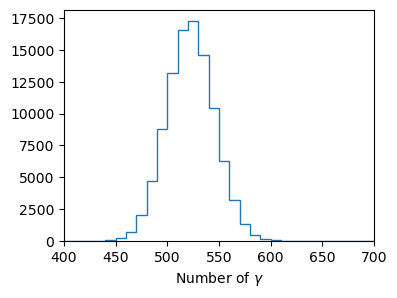

In [15]:
fig, ax = plt.subplots( figsize = ( 4, 3 ))

ax.hist(numGammaPerEvent, bins = np.linspace(0, 800, 81), histtype = 'step')
ax.set_xlabel(r'Number of $\gamma$')
ax.set_xlim( [400, 700] )